# KNN computational time

Trying to convert ratings.csv, which is user-ratings-movieId triplet into user-item interaction matrix crashes the PC. No logs on that. This is before I encounter Surprise library which is supposed to be able to take in user-ratings-ID triplets as they have optimized the process; Scikit learn still requires into of the matrix. It is a shame that I also have not encountered dense matrices before I went into approximate  nearest neighbour, as Scikit learn is able to handle dense matrices, which might allow me to use kNN for this project. 

I tried to create a KNN algorithm but as shown below, efficiency is of an issue.

In [2]:
import numpy as np
import pandas as pd
import importlib
import time
import matplotlib.pyplot as plt

from numpy.linalg import norm
from sklearn.model_selection import train_test_split

#The reason to create own library was that pandas (as of 30 July 2021) wasn't able to support dataframe where n x m > int32.
#This limit was surpassed during creation of the user-item interaction matrix (resulting dataframe will be 270k x 45k)

#Update 1st August
#There have been a fix, and the fix was implemented manually. Test to be carried out with the resulting numpy matrix 
#if my PC have sufficient memory with sklearn kNN algorithm. It will definitely be faster than my own algorithm 

import NearestNeighbour as nn 

In [10]:
url = "https://media.githubusercontent.com/media/Kojk03/ITI105-Project-Team4/main/Data/ratings.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [5]:
len(df['userId'].unique())

270896

In [6]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [7]:
userList = df_test['userId'].unique()
len(userList)

260902

In [8]:
df_train.shape

(18217002, 4)

In [9]:
importlib.reload(nn)

<module 'NearestNeighbour' from 'C:\\Users\\KennethOng\\Documents\\GitHub\\ITI105-Project-Team4\\NearestNeighbour.py'>

In [10]:
nearestNeighbour = nn.NearestNeighbour(df_train)

In [102]:
start = time.time()

#this is without multiprocessing
recommendations = nearestNeighbour.nearestSimilaritiesNoMP(10,99427)

end = time.time()
print(end - start)

No. of users in list:  84541
Not new user
1292.6442782878876


In [11]:
start = time.time()

#this is with multiprocessing
neighbours = nearestNeighbour.nearestSimilarities(10,99427)

end = time.time()
print(end - start)

No. of users in list:  268943
Not new user
10134.575012922287


In [20]:
#neighbours and distances are exported to csv for later comparison with aNN
dfcsv = pd.DataFrame(neighbours, columns = ['user','distance'])
dfcsv.to_csv('99427distvancelistontest.csv')

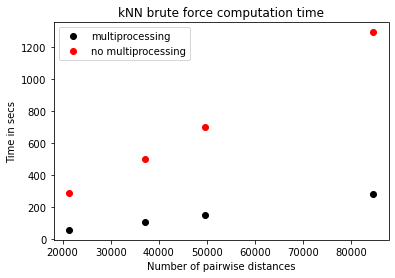

In [7]:
X = [21300, 37010, 49577, 84541]
Y = [58.4, 106.26, 152.83, 285.46]
Y2 = [286.87, 504.19 ,702.11, 1292.64]

plt.plot(X, Y, 'o', color='black',label='multiprocessing');
plt.plot(X, Y2, 'o', color='red',label='no multiprocessing');
plt.title('kNN brute force computation time');
plt.xlabel('Number of pairwise distances');
plt.ylabel('Time in secs');
plt.legend();

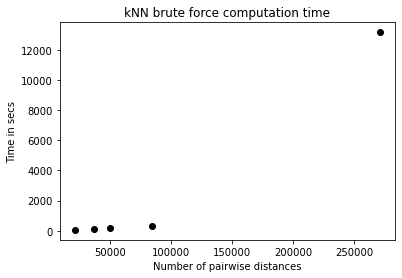

In [76]:
#This computational time needed (with multiprocessing) for 1 user

X = [21300, 37010, 49577, 84541, 270896]
Y = [58.4, 106.26, 152.83, 285.46, 13160.98]

plt.plot(X, Y, 'o', color='black');
plt.title('kNN brute force computation time');
plt.xlabel('Number of pairwise distances');
plt.ylabel('Time in secs');

# Improving of ANN calculation time

In [317]:
#with distance measurement

start = time.time()
temp = nearestNeighbour.userRatingPredict2(99427)
end= time.time()
print(end-start)

93.79451417922974


In [321]:
#without distance measurement

start = time.time()
temp = nearestNeighbour.userRatingPredict2(99427)
end= time.time()
print(end-start)

38.426278829574585


In [90]:
start=time.time()
for i in range(500):
    temp = nearestNeighbour.extractUIMatrix2(99427)
    end=time.time()
print(end-start)

32.41845965385437


total time: 96
time to calcualte ratings: 3s
distance measuremnt of all pairs takes: 55s
time just to extract user-item matrix: 43s

Main components are:
- extracting of user-item matrix
    - This is needed because memory cannot hold the whole matrix
- distance measurement is also dependent on user-item matrix extraction

To reduce computational time, the extraction have to be very much improved.


Making use of h5py library to store user-item matrix on disk and to skip realtime creation of user-item matrix; just read row from on-disk array. Other optimization includes switching from dataframe to array for calculations

In [30]:
start = time.time()

dictionary = nearestNeighbour.generateNeighbours(df_test,1000)
nnMP = nn21.NearestNeighbour(df_train,dictionary)

grandtotalMSE, grandtotalMAE, grandlength, grandnorec= nnMP.calculateScore2(df_test,1000)
end = time.time()
print(end - start)
print(grandtotalMSE, grandtotalMAE, grandlength, grandnorec)

no user in database
no user in database
no user in database
no user in database
no user in database
no user in database
no user in database
[39520, 136048, 160324, 159366, 51478, 163827, 11392, 10461, 111437, 183337, 206164, 63360, 211846, 38188, 79083, 183263, 262537, 57363, 209474, 150462, 225328, 88090, 253343, 98762, 3497, 25308, 81, 62606, 77062, 49767, 66518, 92549, 185035, 91880, 186382, 268471, 222432, 248352, 270121, 200431, 183629, 43667, 96165, 249207, 126043, 250975, 232295, 264907, 227731, 40487, 252056, 185122, 114830, 87639, 47256, 67359, 3218, 264720, 105906, 98180, 231894, 84686, 208176, 22305, 110454, 85541, 249745, 143134, 78127, 219130, 252544, 183047, 74991, 97365, 173598, 195226, 25851, 198271, 4665, 172544, 47180, 251535, 158295, 192344, 151062, 248843, 143991, 25346, 196784, 213089, 267880, 16278, 16269, 183325, 240041, 182666, 270734, 133331, 251922, 61118, 170010, 159452, 58026, 4270, 188898, 167405, 178157, 270291, 75016, 152722, 191189, 242003, 3435, 179346,

After usage of h5py library, average time to calculate rating for 1 user = 4.4s, as compared to previously 93s. However, to calculate ratings for the total of 270k users will still take 330hours (this is already with multi processing)

# Comparison of KNN vs ANN


## Unscaled

In [104]:
#distance from earlier computation of neighbours and distance with ANN

distancedf1 = pd.DataFrame(distance, columns = ['user','distance'])
distancedf1 = distancedf1.sort_values(by = 'distance')
distancedf1 = distancedf1.reset_index()
del distancedf1['index']
distancedf1 = distancedf1.drop(0)
distancedf1.head(10)

,user,distance
1,62164,0.573570
2,24637,0.576859
3,226664,0.603901
4,162456,0.625290
5,105029,0.647508
6,269780,0.677144
7,131611,0.679036
8,150734,0.705543
9,155756,0.712960
10,12282,0.724882


In [66]:
distancedf2 = pd.read_csv('C:/Users/KennethOng/Documents/GitHub/ITI105-Project-Team4/99427distancelistontest.csv')
distancedf2 = distancedf2.drop('Unnamed: 0', axis =1)
distancedf2['distance'] = distancedf2['distance'].map(lambda x: 1-x)
distancedf2 = distancedf2.sort_values(by = 'distance')
distancedf2 = distancedf2.reset_index()
del distancedf2['index']
distancedf2 = distancedf2.drop(0)
distancedf2.head(10)

,user,distance
1,33042,0.515372
2,63054,0.524345
3,13513,0.524653
4,240810,0.531851
5,197286,0.533357
6,70487,0.545106
7,72206,0.545881
8,78339,0.548067
9,148698,0.555683
10,119641,0.556437


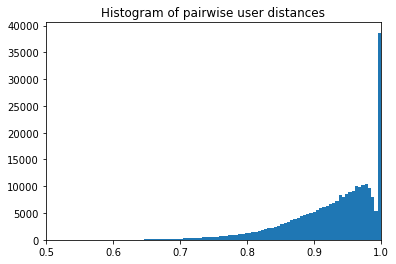

In [355]:
plt.hist(distancedf2['distance'], bins = 100)
plt.title('Histogram of pairwise user distances')
#plt.ylim(0,12000)
plt.xlim(0.5,1);

In [99]:
def findRanking(user):
    return distancedf2[distancedf2['user']==user].index.tolist()[0]

In [106]:
distancedf1['ranking']=distancedf1['user'].apply(findRanking)
distancedf1['distance difference'] = distancedf1['distance']-distancedf2['distance']
distancedf1.head(20)

,user,distance,ranking,distance difference
1,62164,0.573570,24,0.058198
2,24637,0.576859,26,0.052513
3,226664,0.603901,86,0.079248
4,162456,0.625290,205,0.093439
5,105029,0.647508,422,0.114151
6,269780,0.677144,990,0.132038
7,131611,0.679036,1045,0.133155
8,150734,0.705543,2046,0.157476
9,155756,0.712960,2439,0.157276
10,12282,0.724882,3201,0.168445


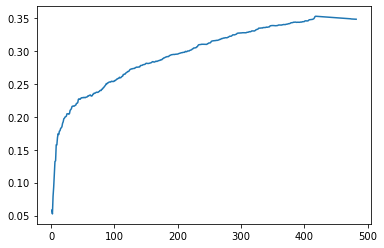

In [112]:
plt.plot(distancedf1.index,distancedf1['distance difference']);

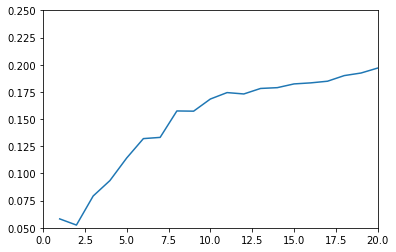

In [199]:
plt.plot(distancedf1.index,distancedf1['distance difference']);
plt.ylim(0.05,0.25)
plt.xlim(0,20);

In [350]:
userItems = df_test[df_test['userId']==99427]
movieList = userItems['movieId'].unique()

neighbours = randomdf.head(50)

movies = df_train['movieId'].unique()
        
array = []
for user in neighbours['user']:
    series = nearestNeighbour.extractUIMatrix3(user)
    series = series.reshape(1,-1)
    if len(array)!=0:
        array = np.append(array, series, axis = 0)
    else:
        array = series
movies = np.sort(movies)
df = pd.DataFrame(array, columns = movies)
df= df.replace(0,np.nan)
ratings = df.mean(axis = 0)
        
totalMSE = 0
totalMAE = 0
length = len(movieList)
#print(length)
predictions =[]
for movie in movieList:
    if movie in movies:
        if np.isnan(ratings[movie]):
            print('movie do not exist in recommendations')
            r = 0
        else:
            r = ratings[movie]
        totalMSE = totalMSE + ((r-userItems[userItems['movieId']==movie]['rating'].values[0])**2)
        totalMAE = totalMAE + abs((r-userItems[userItems['movieId']==movie]['rating'].values[0]))
        predictions.append([movie,r])
        #print(r)
        #print(total)
    else:
        print('Movie not in original list')
        length = length -1

print('TotalMSE: ',totalMSE)
print('TotalMAE: ',totalMAE)
print('Length: ', length)
print(np.sqrt(totalMSE/length), totalMAE/length)

movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not

In [193]:
predictionsdf = pd.DataFrame(predictions,columns=['movie','rating'])
predictionsdf.sort_values(by='rating',ascending=False).head(10)

,movie,rating
84,926,4.500000
154,760,4.500000
35,28,4.500000
131,858,4.473333
55,1237,4.450000
9,750,4.400000
95,1136,4.345070
103,627,4.333333
93,908,4.319149
37,1225,4.318182


In [351]:
ratingsdf = pd.DataFrame(ratings, columns = ['rating'])
ratingsdf = ratingsdf.sort_values(by='rating',ascending = False)
ratingsdftemp = ratingsdf

In [352]:
ratingsdf

,rating
129032,5.0
4642,5.0
4537,5.0
4479,5.0
302,5.0
...,...
176267,NaN
176269,NaN
176271,NaN
176273,NaN


In [353]:
ratingscount = df.count()
ratingscount = ratingscount[ratingscount!=0]
ratingscount = ratingscount[ratingscount!=1]
ratingscount.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,    10,    11,
               12,
            ...
            26729, 31685, 33794, 34405, 38038, 40629, 40819, 56367, 58559,
            72998],
           dtype='int64', length=1223)

In [354]:
ratingsdftemp = ratingsdftemp.loc[ratingscount.index]
ratingsdftemp.sort_values(by='rating',ascending=False).head(20)

,rating
307,5.00
3252,5.00
2973,5.00
1233,5.00
4226,5.00
6016,5.00
1185,5.00
1211,5.00
1834,5.00
1273,5.00


In [203]:
userList = df_train['userId'].unique()
random.seed(10)
neighboursRandom = []
for _ in range(483):
    index = random.randint(0,len(tempusers)+1)
    user = userList[index]
    neighboursRandom.append(user)
neighboursRandom

[209112,
 54167,
 116766,
 86392,
 67320,
 111294,
 180276,
 70415,
 267596,
 127440,
 65858,
 121759,
 223572,
 219773,
 215515,
 161635,
 198966,
 219321,
 44190,
 21144,
 136228,
 206548,
 196542,
 259391,
 125771,
 118572,
 215495,
 186281,
 160495,
 91849,
 198508,
 173330,
 203481,
 161647,
 138380,
 169748,
 170580,
 41588,
 139760,
 239333,
 22045,
 199377,
 110728,
 46228,
 4961,
 232297,
 65803,
 24634,
 163790,
 105512,
 33517,
 235842,
 196130,
 249128,
 51041,
 25410,
 223182,
 236331,
 102865,
 31319,
 153734,
 166109,
 9412,
 212323,
 268662,
 214824,
 155299,
 26857,
 245321,
 181452,
 147694,
 208556,
 234409,
 27178,
 141253,
 221644,
 47139,
 13557,
 118765,
 214263,
 163156,
 12849,
 144024,
 91726,
 59596,
 39259,
 114760,
 76288,
 54536,
 255167,
 116852,
 146887,
 71784,
 228497,
 240407,
 103884,
 3125,
 120981,
 64868,
 227433,
 230990,
 218946,
 203388,
 136841,
 53873,
 71208,
 204608,
 16813,
 79541,
 239107,
 256781,
 39747,
 133874,
 156519,
 19371,
 99932

In [218]:
distanceRandom = nearestNeighbour.calculateDistances(neighboursRandom,99427)
randomdf = pd.DataFrame(distanceRandom, columns = ['user','distance'])
randomdf = randomdf.sort_values(by = 'distance')
randomdf = randomdf.reset_index()
randomdf.index += 1
del randomdf['index']
randomdf.head(10)

,user,distance
1,135824,0.652235
2,216073,0.704407
3,24450,0.711409
4,268721,0.714641
5,86392,0.717711
6,84233,0.727844
7,217471,0.728341
8,27870,0.739029
9,239107,0.743261
10,215515,0.743762


In [219]:
randomdf['ranking']=randomdf['user'].apply(findRanking)
randomdf['distance difference'] = randomdf['distance']-distancedf2['distance']
randomdf.head(20)

,user,distance,ranking,distance difference
1,135824,0.652235,491,0.136863
2,216073,0.704407,1992,0.180062
3,24450,0.711409,2346,0.186756
4,268721,0.714641,2544,0.182790
5,86392,0.717711,2730,0.184354
6,84233,0.727844,3457,0.182738
7,217471,0.728341,3497,0.182460
8,27870,0.739029,4370,0.190962
9,239107,0.743261,4760,0.187578
10,215515,0.743762,4814,0.187325


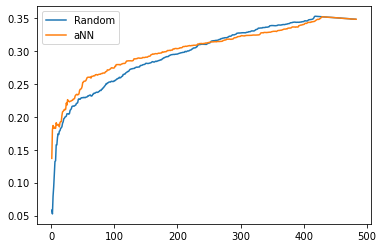

In [224]:
plt.plot(distancedf1.index,distancedf1['distance difference'], label='Random');
plt.plot(randomdf.index,randomdf['distance difference'],label='aNN');
plt.legend();

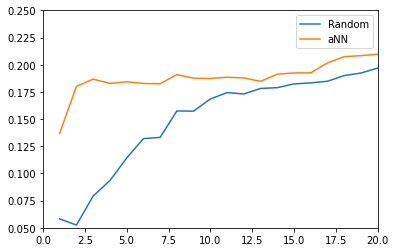

In [227]:
plt.plot(distancedf1.index,distancedf1['distance difference'], label='Random');
plt.plot(randomdf.index,randomdf['distance difference'],label='aNN');
plt.legend();
plt.ylim(0.05,0.25)
plt.xlim(0,20);

In [253]:
userItems = df_test[df_test['userId']==99427]
movieList = userItems['movieId'].unique()

neighbours = randomdf.head(10)

movies = df_train['movieId'].unique()
        
array = []
for user in neighbours['user']:
    series = nearestNeighbour.extractUIMatrix3(user)
    series = series.reshape(1,-1)
    if len(array)!=0:
        array = np.append(array, series, axis = 0)
    else:
        array = series
movies = np.sort(movies)
df = pd.DataFrame(array, columns = movies)
df= df.replace(0,np.nan)
ratings = df.mean(axis = 0)
        
totalMSE = 0
totalMAE = 0
length = len(movieList)
#print(length)
predictions =[]
for movie in movieList:
    if movie in movies:
        if np.isnan(ratings[movie]):
            print('movie do not exist in recommendations')
            r = 0
        else:
            r = ratings[movie]
        totalMSE = totalMSE + ((r-userItems[userItems['movieId']==movie]['rating'].values[0])**2)
        totalMAE = totalMAE + abs((r-userItems[userItems['movieId']==movie]['rating'].values[0]))
        predictions.append([movie,r])
        #print(r)
        #print(total)
    else:
        print('Movie not in original list')
        length = length -1

print('TotalMSE: ',totalMSE)
print('TotalMAE: ',totalMAE)
print('Length: ', length)
print(np.sqrt(totalMSE/length), totalMAE/length)

movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not exist in recommendations
movie do not

In [255]:
predictionsdf = pd.DataFrame(predictions,columns=['movie','rating'])
predictionsdf.sort_values(by='rating',ascending=False).head(10)

,movie,rating
52,1278,5.000000
88,1219,5.000000
20,1198,4.666667
101,1177,4.500000
121,232,4.500000
95,1136,4.500000
103,627,4.500000
9,750,4.500000
144,111,4.500000
109,296,4.428571


## After scaling and comparison with multiple hash tables

In [28]:
knndf = pd.read_csv('C:/Users/KennethOng/Documents/GitHub/ITI105-Project-Team4/99427distancelistontestscaled.csv')

(0.0, 6000.0)

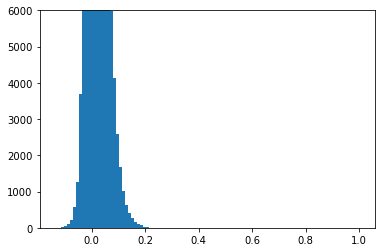

In [8]:
plt.hist(knndf['distance'],bins=100);
plt.ylim(0,6000)

In [146]:
anndf10 = pd.read_csv('C:/Users/KennethOng/Documents/GitHub/ITI105-Project-Team4/99427distancelistontestscaled10tables.csv')

In [27]:
anndf5 = pd.read_csv('C:/Users/KennethOng/Documents/GitHub/ITI105-Project-Team4/99427distancelistontestscaled5tables.csv')

In [148]:
anndf8 = pd.read_csv('C:/Users/KennethOng/Documents/GitHub/ITI105-Project-Team4/99427distancelistontestscaled8.csv')

In [35]:
anndf83 = pd.read_csv('C:/Users/KennethOng/Documents/GitHub/ITI105-Project-Team4/99427distancelistontestscaled83.csv')

In [10]:
random = [209112,
 54167,
 116766,
 86392,
 67320,
 111294,
 180276,
 70415,
 267596,
 127440,
 65858,
 121759,
 223572,
 219773,
 215515,
 161635,
 198966,
 219321,
 44190,
 21144,
 136228,
 206548,
 196542,
 259391,
 125771,
 118572,
 215495,
 186281,
 160495,
 91849,
 198508,
 173330,
 203481,
 161647,
 138380,
 169748,
 170580,
 41588,
 139760,
 239333,
 22045,
 199377,
 110728,
 46228,
 4961,
 232297,
 65803,
 24634,
 163790,
 105512,
 33517,
 235842,
 196130,
 249128,
 51041,
 25410,
 223182,
 236331,
 102865,
 31319,
 153734,
 166109,
 9412,
 212323,
 268662,
 214824,
 155299,
 26857,
 245321,
 181452,
 147694,
 208556,
 234409,
 27178,
 141253,
 221644,
 47139,
 13557,
 118765,
 214263,
 163156,
 12849,
 144024,
 91726,
 59596,
 39259,
 114760,
 76288,
 54536,
 255167,
 116852,
 146887,
 71784,
 228497,
 240407,
 103884,
 3125,
 120981,
 64868,
 227433,
 230990,
 218946,
 203388,
 136841,
 53873,
 71208,
 204608,
 16813,
 79541,
 239107,
 256781,
 39747,
 133874,
 156519,
 19371,
 99932,
 138587,
 148082,
 153548,
 215068,
 26562,
 246163,
 268355,
 82510,
 153935,
 864,
 79762,
 230361,
 154062,
 135840,
 213001,
 193284,
 134694,
 178682,
 161553,
 31622,
 40516,
 212852,
 124007,
 137830,
 30941,
 24450,
 44528,
 45646,
 165476,
 181667,
 225446,
 173804,
 39949,
 115685,
 247632,
 35896,
 269516,
 117421,
 159316,
 56967,
 211229,
 189588,
 70048,
 158405,
 268721,
 29796,
 125373,
 209301,
 261497,
 229157,
 217425,
 164967,
 142996,
 252781,
 198819,
 26764,
 155903,
 172132,
 74693,
 2766,
 59876,
 57093,
 22476,
 11518,
 220445,
 202426,
 85403,
 214199,
 198144,
 8184,
 174063,
 161477,
 268299,
 114344,
 186140,
 241130,
 205138,
 15818,
 212533,
 264767,
 75932,
 73108,
 124489,
 105347,
 127085,
 135824,
 68873,
 32193,
 109076,
 113302,
 187347,
 70519,
 164822,
 75010,
 23749,
 127186,
 183588,
 266073,
 83962,
 175246,
 164446,
 194063,
 203181,
 60642,
 48129,
 48793,
 14654,
 28833,
 148143,
 201766,
 92741,
 256282,
 252482,
 180108,
 241414,
 238952,
 264987,
 59733,
 38640,
 100136,
 177883,
 82070,
 243360,
 55384,
 38613,
 51610,
 269289,
 18589,
 168106,
 147846,
 229904,
 106065,
 95591,
 105542,
 73434,
 145639,
 197063,
 270002,
 134270,
 110117,
 195431,
 207691,
 175595,
 126329,
 174218,
 227367,
 226713,
 239168,
 162511,
 189518,
 91680,
 195702,
 86253,
 184318,
 53381,
 4594,
 51566,
 207913,
 96400,
 154248,
 205860,
 28605,
 130086,
 75320,
 255357,
 148902,
 35634,
 267162,
 18583,
 80216,
 41229,
 17440,
 267632,
 128499,
 177229,
 113765,
 74224,
 255245,
 196360,
 217471,
 158919,
 129118,
 246061,
 148153,
 171645,
 168874,
 10795,
 120324,
 164006,
 221126,
 185895,
 207403,
 71149,
 219874,
 22051,
 156044,
 112959,
 10926,
 95641,
 136400,
 245600,
 261138,
 183614,
 61174,
 247177,
 184400,
 19949,
 42575,
 236230,
 200933,
 23473,
 83037,
 55908,
 67752,
 223078,
 140177,
 50419,
 170338,
 59782,
 121317,
 27778,
 61673,
 58464,
 212420,
 228059,
 42875,
 80555,
 176760,
 165141,
 106002,
 213699,
 59943,
 73404,
 255890,
 143329,
 110528,
 167647,
 216073,
 91693,
 219325,
 53850,
 158633,
 84233,
 48792,
 257323,
 62121,
 48752,
 253774,
 82150,
 57329,
 74693,
 225066,
 212584,
 125705,
 165076,
 148462,
 167228,
 255343,
 213030,
 200553,
 37727,
 60999,
 229840,
 225854,
 177382,
 89109,
 234475,
 142470,
 248465,
 14697,
 245135,
 165569,
 153826,
 257844,
 37922,
 258639,
 76968,
 226401,
 150975,
 42507,
 248800,
 195699,
 58876,
 22532,
 19339,
 228661,
 43760,
 82780,
 95524,
 110282,
 114610,
 141192,
 166163,
 72790,
 210879,
 15513,
 249488,
 68901,
 110280,
 37786,
 154263,
 217986,
 157917,
 169189,
 216767,
 24870,
 79477,
 97169,
 145229,
 213348,
 171123,
 235475,
 160359,
 105510,
 91040,
 112578,
 264512,
 180778,
 208232,
 141606,
 84473,
 27870,
 13880,
 61833,
 214347,
 196902,
 23528,
 125097,
 232272,
 18429,
 36427,
 66803,
 140460,
 237444,
 56038,
 9752,
 199065,
 116877,
 259223,
 177747,
 260749,
 29527,
 204086,
 170609,
 37126,
 139541,
 19509,
 103761,
 204887,
 210699,
 180330,
 112559,
 92365,
 247159,
 87145,
 177868,
 203952,
 256357,
 253417,
 266390,
 115670,
 190653,
 268891,
 115400,
 216294,
 127733,
 104705]

In [173]:
dic = {}
for user in random:
    v1 = nearestNeighbour.extractUIMatrix3(99427)
    v2 = nearestNeighbour.extractUIMatrix3(user)
    distance = spatial.distance.cosine(v1,v2)
    dic[user] = distance
dic

C:\Users\KennethOng\anaconda3\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


{209112: 0.9906839350525635,
 54167: 0.9432486346124538,
 116766: 0.9649455448849094,
 86392: 0.8398786409428882,
 67320: nan,
 111294: 1.0,
 180276: 0.9946937632245166,
 70415: 0.9520775789821336,
 267596: 0.9711746308860453,
 127440: 1.016976211267213,
 65858: 1.005811792920991,
 121759: 1.0314191560319246,
 223572: 1.0,
 219773: 1.0384111197933947,
 215515: 0.8952752986266691,
 161635: 0.9968176928891521,
 198966: 0.881887414375257,
 219321: 0.9645945622603003,
 44190: 0.9711554158170402,
 21144: 0.9425037019803181,
 136228: 0.9827308903475702,
 206548: 1.0,
 196542: 0.9958868698382171,
 259391: 1.063626978655425,
 125771: 0.9615967190648537,
 118572: 1.003726790239163,
 215495: 1.0014867224442678,
 186281: 0.9902613700044184,
 160495: 0.9769076027441198,
 91849: 0.9888285405831119,
 198508: 0.9875881942044429,
 173330: 0.9851595838707953,
 203481: 0.9827624118558053,
 161647: 0.9960456464251688,
 138380: 0.9732951041938345,
 169748: 0.9440380295859961,
 170580: 0.9983096178698887,


In [174]:
randomdf = pd.DataFrame.from_dict(dic, orient='Index')
randomdf['user']= randomdf.index
randomdf['distance']=randomdf[0]
randomdf=randomdf.dropna()
randomdf = randomdf.drop(0,axis=1)
randomdf = randomdf[randomdf['distance']<1]
randomdf = randomdf.sort_values(by='distance',ascending=True)
randomdf = randomdf.reset_index()
del randomdf['index']
randomdf.index = randomdf.index + 1

In [29]:
knndf['distance'] = 1-knndf['distance']
knndf = knndf[knndf['distance']<1]
knndf = knndf.sort_values(by='distance',ascending=True)
# knndf = knndf.reset_index()
# del knndf['index']
knndf

,Unnamed: 0,user,distance
33006,33006,99427,0.000000
50682,50682,156427,0.751163
105584,105584,20792,0.756905
135308,135308,155103,0.757329
17371,17371,147652,0.765169
...,...,...,...
82445,82445,162538,0.999999
255873,255873,112469,1.000000
231240,231240,155202,1.000000
264245,264245,35015,1.000000


In [30]:
knndf = knndf.reset_index()
del knndf['index']
knndf

,Unnamed: 0,user,distance
0,33006,99427,0.000000
1,50682,156427,0.751163
2,105584,20792,0.756905
3,135308,155103,0.757329
4,17371,147652,0.765169
...,...,...,...
169426,82445,162538,0.999999
169427,255873,112469,1.000000
169428,231240,155202,1.000000
169429,264245,35015,1.000000


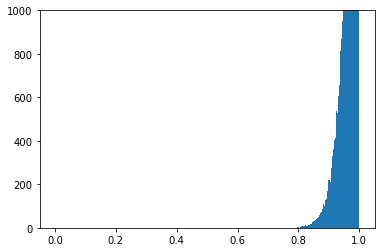

In [195]:
plt.hist(knndf['distance'],bins=1000);
plt.ylim(0,1000);

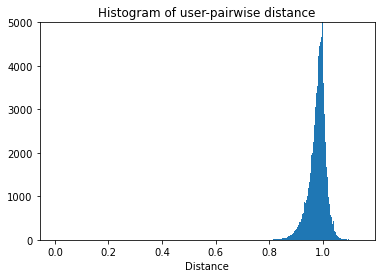

In [25]:
plt.hist(1-knndf['distance'],bins=1000);
plt.title('Histogram of user-pairwise distance');
plt.xlabel('Distance');
plt.ylim(0,5000);

In [153]:
anndf10['distance'] = 1-anndf10['distance']
anndf10 = anndf10[anndf10['distance']<1]
anndf10 = anndf10.sort_values(by='distance',ascending=True)
anndf10 = anndf10.reset_index()
del anndf10['index']
anndf10

,Unnamed: 0,user,distance
0,456,99427,0.000000
1,2730,113398,0.782422
2,2090,136314,0.787963
3,1800,168310,0.797279
4,1203,265138,0.798431
...,...,...,...
2449,2011,54190,0.999734
2450,2151,251134,0.999846
2451,881,165991,0.999915
2452,2711,228044,0.999924


In [31]:
anndf5['distance'] = 1-anndf5['distance']
anndf5 = anndf5[anndf5['distance']<1]
anndf5 = anndf5.sort_values(by='distance',ascending=True)
anndf5 = anndf5.reset_index()
del anndf5['index']

In [ ]:
anndf8['distance'] = 1-anndf8['distance']
anndf8 = anndf8[anndf8['distance']<1]
anndf8 = anndf8.sort_values(by='distance',ascending=True)
anndf8 = anndf8.reset_index()
del anndf8['index']

In [37]:
anndf83['distance'] = 1-anndf83['distance']
anndf83 = anndf83[anndf83['distance']<1]
anndf83 = anndf83.sort_values(by='distance',ascending=True)
anndf83 = anndf83.reset_index()
del anndf83['index']

In [38]:
anndf83.head(10)

,Unnamed: 0,user,distance
0,63,99427,0.000000
1,245,113398,0.782422
2,176,168310,0.797279
3,1,242346,0.811666
4,14,156602,0.835125
5,88,202006,0.837038
6,39,53249,0.845066
7,162,221760,0.845293
8,257,135940,0.845946
9,121,126843,0.849403


In [32]:
def findRanking(user):
    return knndf[knndf['user']==user].index.tolist()[0]

In [175]:
randomdf['ranking']=randomdf['user'].apply(findRanking)
randomdf['distance difference'] = randomdf['distance']-knndf['distance']
randomdf

,user,distance,ranking,distance difference
1,86392,0.839879,355,0.088716
2,187347,0.847557,507,0.090652
3,198966,0.881887,2197,0.124559
4,268355,0.889094,2940,0.123925
5,135824,0.890845,3192,0.121559
...,...,...,...,...
295,91693,0.999737,168732,0.163278
296,57093,0.999818,168980,0.163329
297,23473,0.999856,169078,0.163306
298,29527,0.999875,169131,0.163229


In [158]:
anndf10['ranking']=anndf10['user'].apply(findRanking)
anndf10['distance difference'] = anndf10['distance']-knndf['distance']


In [33]:
anndf5['ranking']=anndf5['user'].apply(findRanking)
anndf5['distance difference'] = anndf5['distance']-knndf['distance']
anndf5


,Unnamed: 0,user,distance,ranking,distance difference
0,257,99427,0.000000,0,0.000000
1,1459,113398,0.782422,12,0.031259
2,1113,136314,0.787963,21,0.031058
3,954,168310,0.797279,33,0.039950
4,628,265138,0.798431,39,0.033262
...,...,...,...,...,...
1284,1506,179107,0.999421,167594,0.130429
1285,362,206402,0.999553,168070,0.130556
1286,1039,94981,0.999605,168264,0.130549
1287,642,199654,0.999710,168632,0.130630


In [34]:
anndf5.head(10)

,Unnamed: 0,user,distance,ranking,distance difference
0,257,99427,0.000000,0,0.000000
1,1459,113398,0.782422,12,0.031259
2,1113,136314,0.787963,21,0.031058
3,954,168310,0.797279,33,0.039950
4,628,265138,0.798431,39,0.033262
5,1020,242346,0.811666,82,0.042379
6,151,17021,0.815594,104,0.043351
7,1619,40369,0.816043,106,0.042834
8,1166,202085,0.818018,121,0.041783
9,690,36045,0.829184,212,0.049945


In [160]:
anndf8['ranking']=anndf8['user'].apply(findRanking)
anndf8['distance difference'] = anndf8['distance']-knndf['distance']


In [40]:
anndf83['ranking']=anndf83['user'].apply(findRanking)
anndf83['distance difference'] = anndf83['distance']-knndf['distance']
anndf83.head(10)

,Unnamed: 0,user,distance,ranking,distance difference
0,63,99427,0.000000,0,0.000000
1,245,113398,0.782422,12,0.031259
2,176,168310,0.797279,33,0.040374
3,1,242346,0.811666,82,0.054337
4,14,156602,0.835125,279,0.069956
5,88,202006,0.837038,303,0.067752
6,39,53249,0.845066,446,0.072824
7,162,221760,0.845293,453,0.072084
8,257,135940,0.845946,467,0.069711
9,121,126843,0.849403,547,0.070165


In [180]:
anndf8

,Unnamed: 0,user,distance,ranking,distance difference
0,117,99427,0.000000,0,0.000000
1,265,40369,0.816043,106,0.064880
2,160,202085,0.818018,121,0.061113
3,30,36045,0.829184,212,0.071855
4,37,179383,0.840093,358,0.074924
...,...,...,...,...,...
318,190,197409,0.999043,166237,0.161669
319,78,232431,0.999058,166283,0.161676
320,23,261586,0.999391,167490,0.161930
321,171,83393,0.999397,167510,0.161935


In [171]:
randomdf.index = randomdf.index+1

In [172]:
randomdf

,user,distance,ranking,distance difference
1,86392,0.839879,355,0.839879
2,187347,0.847557,507,0.096394
3,198966,0.881887,2197,0.124982
4,268355,0.889094,2940,0.131765
5,135824,0.890845,3192,0.125676
...,...,...,...,...
295,91693,0.999737,168732,0.163325
296,57093,0.999818,168980,0.163359
297,23473,0.999856,169078,0.163368
298,29527,0.999875,169131,0.163325


In [162]:
anndf10

,Unnamed: 0,user,distance,ranking,distance difference
0,456,99427,0.000000,0,0.000000
1,2730,113398,0.782422,12,0.031259
2,2090,136314,0.787963,21,0.031058
3,1800,168310,0.797279,33,0.039950
4,1203,265138,0.798431,39,0.033262
...,...,...,...,...,...
2449,2011,54190,0.999734,168718,0.115283
2450,2151,251134,0.999846,169058,0.115391
2451,881,165991,0.999915,169222,0.115455
2452,2711,228044,0.999924,169254,0.115459


In [163]:
anndf5

,Unnamed: 0,user,distance,ranking,distance difference
0,257,99427,0.000000,0,0.000000
1,1459,113398,0.782422,12,0.031259
2,1113,136314,0.787963,21,0.031058
3,954,168310,0.797279,33,0.039950
4,628,265138,0.798431,39,0.033262
...,...,...,...,...,...
1284,1506,179107,0.999421,167594,0.130429
1285,362,206402,0.999553,168070,0.130556
1286,1039,94981,0.999605,168264,0.130549
1287,642,199654,0.999710,168632,0.130630


In [168]:
anndf8['distance difference']

0      0.000000
1      0.064880
2      0.061113
3      0.071855
4      0.074924
         ...   
318    0.161669
319    0.161676
320    0.161930
321    0.161935
322    0.162194
Name: distance difference, Length: 323, dtype: float64

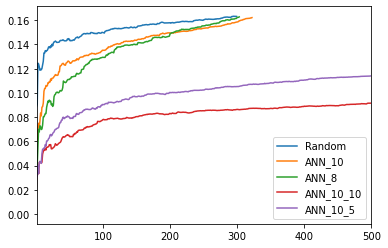

In [209]:
plt.plot(randomdf.index,randomdf['distance difference'],label='Random');
plt.plot(anndf8.index,anndf8['distance difference'], label='ANN_10');
plt.plot(anndf83.index,anndf83['distance difference'], label='ANN_8');
plt.plot(anndf10.index,anndf10['distance difference'],label='ANN_10_10');
plt.plot(anndf5.index,anndf5['distance difference'], label='ANN_10_5');
plt.legend();
plt.xlim(1,500);

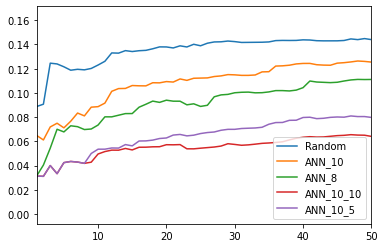

In [210]:
plt.plot(randomdf.index,randomdf['distance difference'],label='Random');
plt.plot(anndf8.index,anndf8['distance difference'], label='ANN_10');
plt.plot(anndf83.index,anndf83['distance difference'], label='ANN_8');
plt.plot(anndf10.index,anndf10['distance difference'],label='ANN_10_10');
plt.plot(anndf5.index,anndf5['distance difference'], label='ANN_10_5');
plt.legend();
plt.xlim(1,50);

In [21]:
import random
random.seed(10)
l=[]
for _ in range(50):
    index = random.randint(0,42232)
    l.append(index)
l

[37447,
 2135,
 28107,
 31625,
 37885,
 972,
 13506,
 30315,
 32197,
 18187,
 10500,
 2254,
 34122,
 32118,
 21480,
 4986,
 16383,
 23668,
 2920,
 27551,
 9089,
 39530,
 23270,
 25008,
 27607,
 18587,
 17191,
 29938,
 11447,
 19864,
 23762,
 8714,
 29945,
 15688,
 28812,
 40194,
 24591,
 2900,
 38203,
 265,
 15443,
 8780,
 12776,
 19848,
 35149,
 23995,
 15740,
 20602,
 35978,
 29532]

In [22]:
import random
random.seed(20)
l2=[]
for _ in range(50):
    index = random.randint(0,42232)
    l2.append(index)
l2

[9909,
 17028,
 41662,
 6652,
 21458,
 37548,
 11100,
 1768,
 26969,
 26656,
 4915,
 6766,
 8197,
 20915,
 31090,
 38054,
 29451,
 26999,
 13674,
 13095,
 20768,
 40984,
 21991,
 21544,
 28008,
 6076,
 41135,
 33937,
 32251,
 26537,
 5338,
 13522,
 37565,
 15901,
 2300,
 13226,
 6194,
 5488,
 12473,
 16608,
 18577,
 19992,
 16828,
 10705,
 40891,
 7713,
 1529,
 17534,
 15332,
 14396]

In [24]:
for index in l:
    if index in l2:
        print('Same!')

# Creation of h5py files

In [63]:
f = h5py.File('D:/Scaled2.h5', 'w')


In [66]:
f.close()

In [ ]:
dic = {}

userTrain = df_train['userId'].unique()
i=0

for user in userTrain:
    print('User ', user)
    print('i ', i)
    matrix = nearestNeighbour.extractUIMatrix2Scaled(user)
    matrix = matrix.values.reshape(1,-1)
    matrix = np.nan_to_num(matrix,nan=0)
    if i==0:
        dset = f.create_dataset("Scaled", data=matrix, maxshape=(None,None),chunks=True)
        dic[user]=i
        i = i+1
    else:
        dset.resize([dset.shape[0]+1,dset.shape[1]])
        dset[i]=matrix[0]
        dic[user]=i
        i=i+1

In [65]:
dic = {}

movieTrain = df_train['movieId'].unique()
i=0

for movie in movieTrain:
    print('i ', i)
    matrix = nearestNeighbour.extractUIMatrixItem(movie)
    matrix = matrix.values.reshape(1,-1)
    matrix = np.nan_to_num(matrix,nan=0)
    if i==0:
        dset = f.create_dataset("Scaled2", data=matrix, maxshape=(None,None),chunks=True)
        dic[movie]=i
        i = i+1
    else:
        dset.resize([dset.shape[0]+1,dset.shape[1]])
        dset[i]=matrix[0]
        dic[movie]=i
        i=i+1

i  0
i  1
i  2
i  3
i  4
i  5
i  6
i  7
i  8
i  9
i  10
i  11
i  12
i  13
i  14
i  15
i  16
i  17
i  18
i  19
i  20
i  21
i  22
i  23
i  24
i  25
i  26
i  27
i  28
i  29
i  30
i  31
i  32
i  33
i  34
i  35
i  36
i  37
i  38
i  39
i  40
i  41
i  42
i  43
i  44
i  45
i  46
i  47
i  48
i  49
i  50
i  51
i  52
i  53
i  54
i  55
i  56
i  57
i  58
i  59
i  60
i  61
i  62
i  63
i  64
i  65
i  66
i  67
i  68
i  69
i  70
i  71
i  72
i  73
i  74
i  75
i  76
i  77
i  78
i  79
i  80
i  81
i  82
i  83
i  84
i  85
i  86
i  87
i  88
i  89
i  90
i  91
i  92
i  93
i  94
i  95
i  96
i  97
i  98
i  99
i  100
i  101
i  102
i  103
i  104
i  105
i  106
i  107
i  108
i  109
i  110
i  111
i  112
i  113
i  114
i  115
i  116
i  117
i  118
i  119
i  120
i  121
i  122
i  123
i  124
i  125
i  126
i  127
i  128
i  129
i  130
i  131
i  132
i  133
i  134
i  135
i  136
i  137
i  138
i  139
i  140
i  141
i  142
i  143
i  144
i  145
i  146
i  147
i  148
i  149
i  150
i  151
i  152
i  153
i  154
i  155
i  156
i  157
i  1

# Creation of hashtables and bucket list

In [93]:
#Generating multiple hashtables and buckets
for name in hashdic.keys():   
    start = time.time()
    nearestNeighbour = nn2.NearestNeighbour(df_train)
    nearestNeighbour.approxSimilaritiesFit(name, randomSeed=hashdic[name]);
    end = time.time()
    print(end-start)

No. of users in list:  268943
0.7550370693206787
No. of users in list:  268943
0.7229642868041992
No. of users in list:  268943
0.7200014591217041
No. of users in list:  268943
0.7329998016357422
No. of users in list:  268943
0.7629992961883545
No. of users in list:  268943
0.7240705490112305
No. of users in list:  268943
0.7139930725097656
No. of users in list:  268943
0.7249369621276855
No. of users in list:  268943
0.7390353679656982
No. of users in list:  268943
1.3631465435028076


In [105]:
#Generating singular hashtable 
start = time.time()
nearestNeighbour = nn2.NearestNeighbour(df_train)
nearestNeighbour.approxSimilaritiesFit('Scaled83', randomSeed=3);
end = time.time()
print(end-start)



No. of users in list:  268943
715.2555677890778


# Unable to use Surprise library due to memory issues

In [36]:
from surprise import KNNBasic
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split

In [15]:
algo = KNNBasic()

In [32]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [37]:
trainset, testset = train_test_split(data, test_size=.30)

In [38]:
algo.fit(trainset)

Computing the msd similarity matrix...


MemoryError: Unable to allocate 539. GiB for an array with shape (268914, 268914) and data type float64